# Importing the dependencies

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from math import exp
import xgboost
from sklearn.model_selection import train_test_split
import category_encoders as ce
from scipy.stats import skew
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,MinMaxScaler,FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from scipy.stats import skew,yeojohnson
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import pickle
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [5]:
import sklearn
print(sklearn.__version__)


1.4.1.post1


In [10]:
def invert_yeojhonson(value, lmbda):
    """
    This function will inverse the yeo-johnson transformation
    """
    if value >= 0 and lmbda == 0:
        return exp(value) - 1
    elif value >= 0 and lmbda != 0:
        return (value * lmbda + 1) ** (1 / lmbda) - 1
    elif value < 0 and lmbda != 2:
        if (2 - lmbda) * value + 1 >= 0:
            return 1 - (-(2 - lmbda) * value + 1) ** (1 / (2 - lmbda))
        else:
            return float('nan')  # or handle it differently based on your requirements
    elif value < 0 and lmbda == 2:
        return 1 - exp(-value)

In [11]:
# Loading the dataset
df = pd.read_csv('../Cleaned_datasets/Combined_CleanData_V4.csv')
df.drop(['store room'],axis=1,inplace=True)
df['sector'] = df['sector'].astype(object)
df.sample(15)

,Property_Type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,furnishing_type,luxury_category,floor_category
870,flat,56.0,1.45,3.0,3.0,3+,Old Property,1900.000000,1.0,1.0,Medium,Mid Floor
86,flat,33.0,1.75,3.0,3.0,0,Under Construction,1996.000000,0.0,1.0,Medium,Low Floor
1503,flat,49.0,2.45,3.0,3.0,3,Relatively New,1865.000000,0.0,1.0,Medium,Low Floor
2617,flat,1.0,0.21,1.0,1.0,0,Relatively New,484.000000,0.0,1.0,Medium,Low Floor
1525,flat,85.0,1.20,2.0,2.0,3+,Relatively New,1491.000000,0.0,2.0,Low,Mid Floor
1989,flat,108.0,1.00,2.0,2.0,2,Relatively New,2060.000000,0.0,1.0,Low,Low Floor
2664,flat,104.0,1.95,3.0,3.0,3+,New Property,2544.000000,1.0,2.0,Low,Mid Floor
386,flat,1.0,0.65,3.0,2.0,3+,Moderately Old,1696.000000,0.0,2.0,Medium,Mid Floor
2370,flat,82.0,0.80,2.0,2.0,3,Relatively New,1383.000000,0.0,1.0,Low,Mid Floor
452,flat,48.0,1.60,3.0,3.0,3+,Old Property,1895.000000,0.0,2.0,Medium,Mid Floor


In [18]:
# Step 1: Get the counts of each sector
sector_counts = df['sector'].value_counts()

# Step 2: Filter sectors with counts greater than 100
sectors_to_keep = sector_counts[sector_counts > 50].index

filtered_df = df[df['sector'].isin(sectors_to_keep)]
filtered_df.shape

(2413, 12)

In [13]:
balcony_map = {'3+ Balconies': '3+', '2 Balconies': '2', '3 Balconies': '3', 'No Balcony': '0', '1 Balcony': '1'}
df['balcony'] = df['balcony'].replace(balcony_map)

In [14]:
new_order = ['balcony', 'agePossession','luxury_category', 'floor_category','Property_Type', 'sector','built_up_area','bedRoom', 'bathroom',
             'servant room','furnishing_type','price']

df = df.reindex(columns=new_order)

In [15]:
# Seperating the data into dependent variable and indepenedent variables
X = df.drop(['price'],axis=1)
y = df['price']

X_train,X_test_val,y_train,y_test_val = train_test_split(X,y,train_size = 0.8,shuffle=True)
X_test,X_val,y_test,y_val = train_test_split(X_test_val,y_test_val,train_size=0.8,shuffle=True)

In [16]:
X_train.shape,X_test.shape,X_val.shape

((2904, 11), (580, 11), (146, 11))

In the input data which we will be feeding into the model for training, there is only 1 feature which is continuous in nature and that is `built_up_area` and to get good results from the linear models, the distribution of continous features must be normal or sort of normal. Thus we will be using some mathematical transformation to transform the skewed distribution into the sort of normal distribution. 

In similar way we will also be using some mathematical transformation on target variable, but to decide which transformation to apply we must be aware about the shape of the variable's distribution, thus we will be using a `histogram` and a `qqplot`

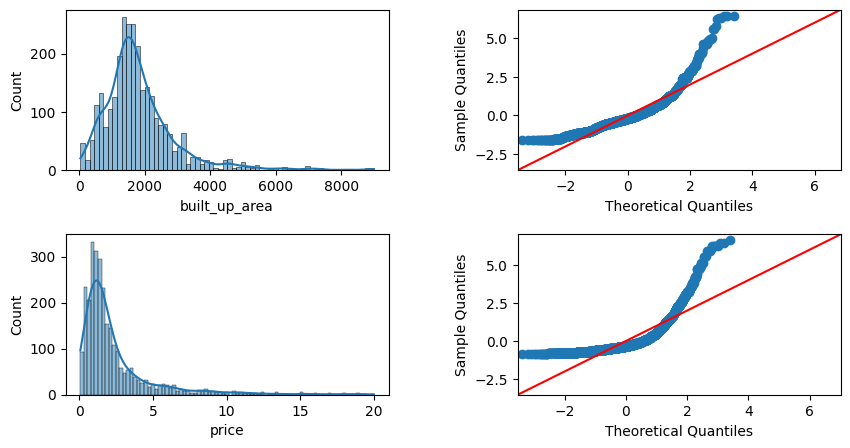

In [17]:
fig, ax = plt.subplots(2, 2, figsize=[10, 5])

sns.histplot(data=X_train, x='built_up_area', kde=True, ax=ax[0][0])
sm.qqplot(X_train['built_up_area'].values, line='45', fit=True, dist=stats.norm,ax=ax[0][1])
sns.histplot(x=y_train, kde=True, ax=ax[1][0])
sm.qqplot(y_train.values, line='45', fit=True, dist=stats.norm,ax=ax[1][1])

plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

In [18]:
temp_df = df.copy()

In [19]:
# Calculate skewness before transformations
before_transformation = {
    'built_up_area': skew(temp_df['built_up_area']),
    'price': skew(temp_df['price'])
}

# Apply square root and cube root transformations
log_transformation = {
    'built_up_area': skew(np.log(temp_df['built_up_area'])),
    'price': skew(np.sqrt(temp_df['price']))
}

# Apply square root and cube root transformations
sqrt_transformation = {
    'built_up_area': skew(np.sqrt(temp_df['built_up_area'])),
    'price': skew(np.sqrt(temp_df['price']))
}

cube_root_transformation = {
    'built_up_area': skew(np.cbrt(temp_df['built_up_area'])),
    'price': skew(np.cbrt(temp_df['price']))
}

# Yeo-Johnson transformation (We have to find our lambda value prior)
yeojohn_transformation = {
    'built_up_area': skew(yeojohnson(temp_df['built_up_area'], yeojohnson(temp_df['built_up_area'])[1])),
    'price': skew(yeojohnson(temp_df['price'],yeojohnson(temp_df['price'])[1]))
}

# Create the DataFrame with all transformations
skew_df = pd.DataFrame({
    'Normal': before_transformation,
    'Log': log_transformation,
    'Sqrt': sqrt_transformation,
    'Cube Root': cube_root_transformation,
    'Yeo-Johnson': yeojohn_transformation,
})
skew_df

,Normal,Log,Sqrt,Cube Root,Yeo-Johnson
built_up_area,2.107325,-1.333799,0.587980,0.040648,0.117186
price,2.946583,1.551624,1.551624,1.109348,0.079611


In [20]:
cbrt_built_area = np.cbrt(temp_df['built_up_area'])
yeo_price = yeojohnson(temp_df['price'], yeojohnson(temp_df['price'])[1])

In [21]:
kurtosis = stats.kurtosis(df['price'])
kurtosis

np.float64(10.97317634146267)

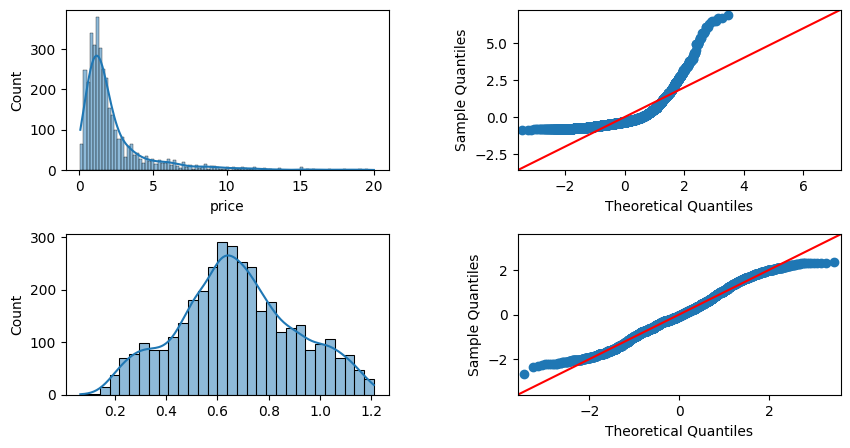

In [22]:
fig, ax = plt.subplots(2, 2, figsize=[10, 5])

sns.histplot(x = df['price'], kde=True, ax=ax[0][0])
sm.qqplot(df['price'], line='45', fit=True, dist=stats.norm,ax=ax[0][1])

sns.histplot(x=yeo_price, kde=True, ax=ax[1][0])
sm.qqplot(yeo_price, line='45', fit=True, dist=stats.norm,ax=ax[1][1])

plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

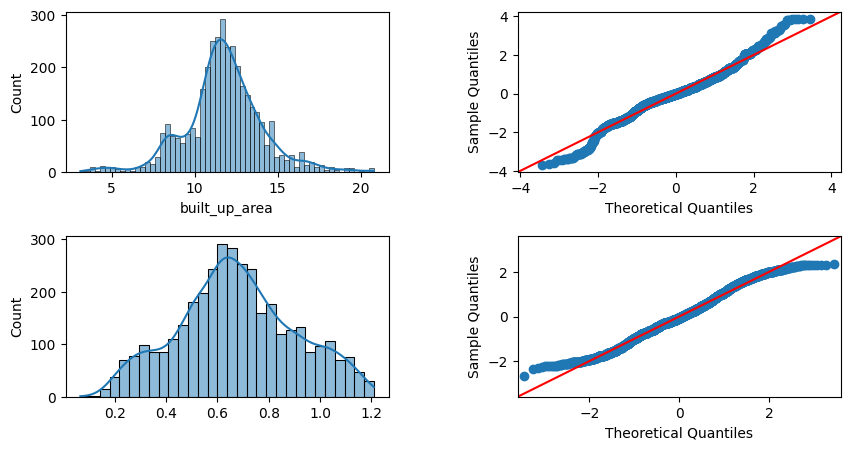

In [23]:
fig, ax = plt.subplots(2, 2, figsize=[10, 5])

sns.histplot(x = cbrt_built_area, kde=True, ax=ax[0][0])
sm.qqplot(cbrt_built_area, line='45', fit=True, dist=stats.norm,ax=ax[0][1])

sns.histplot(x=yeo_price, kde=True, ax=ax[1][0])
sm.qqplot(yeo_price, line='45', fit=True, dist=stats.norm,ax=ax[1][1])

plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

In [24]:
df.shape

(3630, 12)

# Processsing Pipeline
Before training our model it is very much important to first transform the data into the form which the model accepts (Numbers). In the feature selection file we build a base model and that model was performing average, so now in this file our aim will be to use the best set of techniques for encoding the categorical data, as well as performing any necessary mathematical transformations on the numerical features to get the best possible model with current data we are having at hand.

In this module we will focusing on performing 3 different operations ⬇️
- Encoding categorical data
- Applying mathematical transformation to make skewed feature: sort of normal
- Scale the feature values to common scale

#### Step 1: Encoding categorical features
- In our dataset property type and sector are 2 nominal features
- Age possession, luxury cateogry and floor category are ordinal features

`Note`: An important thing that we need to keep in mind is that the feature `sector` is having high cardinality so one hot encoding may lead to curse of dimensionality, so we need to test that for this feature whether one hot encoding or target encoding will work. 

- One hot encoding : Property_type
- Target encoding : Sector
- Ordinal encoding : balcony, age possesion,luxury category,floor category

In [25]:
# Defining the function for doing the cube root transformation
def cube_root_transform(column):
    return np.cbrt(column)

In [26]:
# Column transformer for doing ordinal and nominal encoding
encoding_transformer = ColumnTransformer(transformers=[
    ('Encode_balcony', OrdinalEncoder(categories=[['0', '1', '2', '3', '3+']],
                                     handle_unknown="use_encoded_value", unknown_value=np.nan), [0]),

    ('Encode_AgeP', OrdinalEncoder(categories=[['Under Construction', 'New Property', 'Relatively New',
                                                'Moderately Old', 'Old Property']],
                                   handle_unknown="use_encoded_value", unknown_value=np.nan), [1]),

    ('Encode_Lux', OrdinalEncoder(categories=[['Low', 'Medium', 'High']],
                                  handle_unknown="use_encoded_value", unknown_value=np.nan), [2]),

    ('Encode_Floor', OrdinalEncoder(categories=[['Low Floor', 'Mid Floor', 'High Floor']],
                                    handle_unknown="use_encoded_value", unknown_value=np.nan), [3]),

    ('Encode_PropT', OneHotEncoder(handle_unknown='ignore', drop='first'), [4]),
    
    ('Encode_sector', ce.TargetEncoder(cols=['sector']), [5]),
], remainder='passthrough')


# Column transformer for mathematical transformation CoapplicantIncome, loan amount
math_transformer = ColumnTransformer(transformers=[
    ('cubroot_built_up_area', FunctionTransformer(func=np.cbrt), [6]),
], remainder='passthrough')

# Column transformer for doing feature scaling
scaling_transformer = ColumnTransformer(transformers = [
    ('MinMaxScaling',MinMaxScaler(copy=False),[0,1,2,3,4,6,7,8,10])],remainder='passthrough')


# Stacking column transformers to create a Processing pipeline
Processing_pipeline = Pipeline(steps = [('Encoding',encoding_transformer),
                                        ('Transformation',math_transformer),
                             ('Scaling',scaling_transformer)],memory='Temp')

In [27]:
# Transforming the input data
X_train_temp = Processing_pipeline.fit_transform(X_train,y_train)

ImportError: cannot import name 'is_scalar_nan' from 'sklearn.utils' (d:\Projects\FindHome.AI\.venv\Lib\site-packages\sklearn\utils\__init__.py)

In [38]:
# Transforming the training data
lambda_value = yeojohnson(y_train)[1]
y_train_transformed = yeojohnson(y_train, lambda_value)

In [17]:
# Save the data to a file using pickle
with open('../Model Building/Pipeline.pkl', 'wb') as file:
    pickle.dump(Processing_pipeline, file)

In [18]:
# scores.mean(),scores.std()

In [39]:
def scorer(model_name, model):
    """
    This function will take a model name as input and inject that model into the training pipeline to process 
    and train the model by using the training data. After that this function will use K fold cross validation technique
    to calculate the average (r2 score) and the mean absolute error
    """
    
    output = []
    output.append(model_name)
    
    # Stacking column transformers to create a Training pipeline
    Training_pipeline = Pipeline(steps = [('Encoding',encoding_transformer),
                             ('Scaling',scaling_transformer),
                             ('Transformation',math_transformer),
                             ('regressor', model)])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(Training_pipeline, X_train, y_train_transformed, cv=kfold, scoring='r2')
    output.append(scores.mean())
    
    # Training the model and getting predictions
    Training_pipeline.fit(X_train,y_train_transformed)
    y_pred_tranformed = Training_pipeline.predict(X_test)
    y_pred_inverse = [invert_yeojhonson(x, lambda_value) for x in y_pred_tranformed]
    # # y_pred = np.expm1(y_pred)
    output.append(mean_absolute_error(y_test,y_pred_inverse))
    
    return output

In [40]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'xgboost':XGBRegressor()
}

In [24]:
%%time
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [22]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])
model_df.sort_values(['mae'])

,name,r2,mae


# Regression Analysis

In [41]:
y_train_transformed

array([0.4387563 , 0.45811327, 0.51081993, ..., 0.64415915, 1.09011626,
       0.66518139])

In [45]:
# Add a constant term of 1 for the intercept to each row
X_train_temp = sm.add_constant(X_train_temp)

# Train the OLS model
regression_analysis_model = sm.OLS(y_train_transformed, X_train_temp).fit()
print(regression_analysis_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     863.3
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        19:57:33   Log-Likelihood:                 2280.3
No. Observations:                2904   AIC:                            -4537.
Df Residuals:                    2892   BIC:                            -4465.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1585      0.013     12.465      0.0

In [ ]:
with open('regression_analysis_model.pkl', 'wb') as f:
    pickle.dump(regression_analysis_model, f)

In [ ]:
print(regression_analysis_model.summary()) 

# Hyper parameter optimization 
HYPEROPT is a powerful python library that uses bayesian optimization to search through an hyperparameter space of values and find the best possible values that yield the minimum of the loss function.The optimization process consists of 4 parts which are as follows-

1. **Initialize domain space**
The domain space is the input values over which we want to search.

2. **Define objective function**
The objective function can be any function which returns a real value that we want to minimize. In this case, we want to minimize the validation error of a machine learning model with respect to the hyperparameters. If the real value is accuracy, then we want to maximize it. Then the function should return the negative of that metric.

3. **Optimization algorithm**
It is the method used to construct the surrogate objective function and choose the next values to evaluate.

4. **Results**
Results are score or value pairs that the algorithm uses to build the model.

In [42]:
X_train = Processing_pipeline.fit_transform(X_train,y_train)
X_test = Processing_pipeline.transform(X_test)

In [48]:
# Defining the domain space
space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': 180,
    'seed': 0 }


def objective(space):
    model = XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=int(space['min_child_weight']),
        random_state=space['seed'])

    # Training the model
    model.fit(X_train, )

    # Getting predictions from the trained model and computing mean absolute error
    y_pred_processed = model.predict(X_test)
    y_pred_inverse = [invert_yeojhonson(x, lambda_value) for x in y_pred_processed]
    # y_pred = np.expm1(y_pred)
    mae = mean_absolute_error(y_test, y_pred_inverse)
    print("MAE:", mae)
    return {'loss': mae, 'status': STATUS_OK }

In [49]:
trials = Trials()
best_hyperparams = fmin(fn=objective,space=space,algo=tpe.suggest,max_evals=100,trials=trials)

MAE:                                                                                                                   
0.6669669280894467                                                                                                     
MAE:                                                                                                                   
0.7660112113189567                                                                                                     
MAE:                                                                                                                   
0.7965019415743345                                                                                                     
MAE:                                                                                                                   
0.7774294847553946                                                                                                     
MAE:                                    

In [50]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.6743052717985774, 'gamma': 0.00011922891462700334, 'max_depth': 14.0, 'min_child_weight': 1.0, 'reg_alpha': 0.7266611391921619, 'reg_lambda': 0.7854718550040956}


# Model training

In [51]:
# Create the XGBoost Regressor with the best hyperparameters
regressor = XGBRegressor(
    max_depth=int(best_hyperparams['max_depth']),
    gamma=best_hyperparams['gamma'],
    reg_alpha=best_hyperparams['reg_alpha'],
    reg_lambda=best_hyperparams['reg_lambda'],
    colsample_bytree=best_hyperparams['colsample_bytree'],
    min_child_weight=best_hyperparams['min_child_weight'],
    n_estimators=180,
    random_state=0)

# Training the model
regressor.fit(X_train,y_train_transformed)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6743052717985774, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.00011922891462700334,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=1.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=180, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

# Model evaluation

In [52]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(regressor, X_train, y_train, cv=kfold, scoring='r2')
print("Average R2 SCORE : ",scores.mean())

Average R2 SCORE :  0.8164974876540582


In [43]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(regressor, X_train, y_train, cv=kfold, scoring='r2')
print("Average R2 SCORE : ",scores.mean())

Average R2 SCORE :  0.8908036551397064


In [44]:
# Getting predictions
y_pred = regressor.predict(X_test)
y_pred = np.expm1(y_pred)
print("Mean Absolute error:",mean_absolute_error(y_test,y_pred))

Mean Absolute error: 0.4317201067960564


In [ ]:
# Load the array from the pickle file
with open('array.pkl', 'rb') as f:
    loaded_array = pickle.load(f)

In [59]:
# Save the array as a pickle file
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [57]:
X_test

array([[0.31144055, 0.5       , 0.25      , ..., 0.5       , 1.        ,
        0.        ],
       [0.46642605, 0.75      , 0.25      , ..., 0.5       , 1.        ,
        0.        ],
       [0.91572941, 1.        , 0.25      , ..., 0.5       , 0.        ,
        1.        ],
       ...,
       [0.42263097, 1.        , 0.5       , ..., 1.        , 1.        ,
        1.        ],
       [0.53120308, 1.        , 0.5       , ..., 1.        , 1.        ,
        0.        ],
       [0.53847561, 1.        , 0.25      , ..., 1.        , 1.        ,
        1.        ]])

In [56]:
y_test

1949     0.26
2697     1.75
3433    19.50
773      2.30
2283     4.10
        ...  
383      2.35
2118     0.80
1773     1.10
2608     2.20
659      1.50
Name: price, Length: 580, dtype: float64

# Saving the trained Model

In [45]:
# Specify the file path where you want to save the model
model_path = 'Trained_Model/xgboost_regressor_model.bin'

# Save the model to the specified file
regressor.save_model(model_path)